![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Seq2seq Sunspot

## Introduction 
This tutorial demonstrates building `LSTM Sequence to Sequence` (`Seq2Seq`) model with [daily sunspot data](https://www.kaggle.com/abhinand05/daily-sun-spot-data-1818-to-2019/version/2).<br>
## What will we accomplish?
1. Apply Seq2Seq model to the Sunspot data.
2. Apply data exploratory to the Sunspot data.
3. Save and load the model.

## Notebook Outline
Below is the outline for this tutorial
1. [Hyperparameter](#Hyperparameter)
2. [Data Preparation](#DataPreparation)
3. [Data Visualization](#DataVisualization)
4. [Data Preprocessing](#DataPreprocessing)
4. [Data Splitting](#DataSpliting)
5. [Data Scaling ](#DataScaling )
6. [Data Transform](#DataTransform)
7. [Data Sequencing](#DataSequencing)
8. [Data Iterator](#DataIterator)
9. [Model building](#Modelbuilding)
10. [Input Model](#InputModel)
11. [Training](#Training)
12. [Save and Load Model](#SaveandLoadModel)
12. [Model Evaluation](#ModelEvaluation)
    * [Inverse Scale Transform](#InverseScaleTransform)
    * [Forecast Data Evaluation](#ForecastDataEvaluation)
    * [Forecast Plot](#ForecastPlot)
13. [Summary](#Summary)
14. [Reference](#Reference)

First, let's import the package needed.

In [1]:
#  Import libary
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from torchsummaryX import summary
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
%matplotlib inline

## <a name="Hyperparameter">Hyperparameter

In [2]:
split_ratio =  0.7
num_features = 1
num_hidden = 50
num_output = 1
num_epochs = 100
window_size = 21
num_futures = 1
batch_size = 14

## <a name="DataPreparation">Data Preparation
>**Instruction** : <br>
Read the `CSV` file using `pd.read_csv`<br>
Your file path `../../datasets/others/sunspot.csv`
    
>**Expected Result** : <br>
Example of the first 5 data

---|year|	month|	day|	decimal_date|	total_sunspot_number|	std_dev|	num_observation|	provisional_indicator
---|---|	---|	---|	---|	---|	---|	---|	---
0|	1818|	1|	1|	1818.001|	-1|	-1.0|	0|	1
1|	1818|	1|	2|	1818.004|	-1|	-1.0|	0|	1
2|	1818|	1|	3|	1818.007|	-1|	-1.0|	0|	1
3|	1818|	1|	4|	1818.010|	-1|	-1.0|	0|	1
4|	1818|	1|	5|	1818.012|	-1|	-1.0|	0|	1    

In [58]:
# Read CSV data
### BEGIN SOLUTION
df = pd.read_csv("../../datasets/others/sunspot.csv", sep=";",header=None)
### END SOLUTION
df.columns = ['year', 'month', 'day', 'decimal_date', 'total_sunspot_number', 'std_dev', 'num_observation', 'provisional_indicator']
df.head()

,year,month,day,decimal_date,total_sunspot_number,std_dev,num_observation,provisional_indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


>**Instruction** : <br>
Concatenate the `year`, `month`, `day` column into `date`<br>

>**Expected Result** : <br>
Example of the first 5 data

date	|year-|	month|	day|	decimal_date|	total_sunspot_number|	std_dev|	num_observation|	provisional_indicator|	date
---|---|	---|	---|	---|	---|	---|	---|	---|---									
1818-01-01|	1818|	1|	1|	1818.001|	-1|	-1.0|	0|	1|	1818-1-1
1818-01-02|	1818|	1|	2|	1818.004|	-1|	-1.0|	0|	1|	1818-1-2
1818-01-03|	1818|	1|	3|	1818.007|	-1|	-1.0|	0|	1|	1818-1-3
1818-01-04|	1818|	1|	4|	1818.010|	-1|	-1.0|	0|	1|	1818-1-4
1818-01-05|	1818|	1|	5|	1818.012|	-1|	-1.0|	0|	1|	1818-1-5

In [4]:
# Concatenate the year, month, day column into date
### BEGIN SOLUTION
df = df.assign(date=df.year.astype('string')+'-'+df.month.astype('string')+'-'+df.day.astype('string'))
df.index = pd.to_datetime(df.date)
### END SOLUTION
df.head()

,year,month,day,decimal_date,total_sunspot_number,std_dev,num_observation,provisional_indicator,date
date,,,,,,,,,
1818-01-01,1818,1,1,1818.001,-1,-1.0,0,1,1818-1-1
1818-01-02,1818,1,2,1818.004,-1,-1.0,0,1,1818-1-2
1818-01-03,1818,1,3,1818.007,-1,-1.0,0,1,1818-1-3
1818-01-04,1818,1,4,1818.010,-1,-1.0,0,1,1818-1-4
1818-01-05,1818,1,5,1818.012,-1,-1.0,0,1,1818-1-5


>**Instruction** : <br>
Drop the unwanted column `year`, `month`, `day`, `date`, `decimal_date`<br>

>**Expected Result** : <br>
Example of the first 5 data

date	|total_sunspot_number|	std_dev|	num_observation|	provisional_indicator
---	|---	|	---	|	---	|	---					
1818-01-01|	-1|	-1.0|	0|	1
1818-01-02|	-1|	-1.0|	0|	1
1818-01-03|	-1|	-1.0|	0|	1
1818-01-04|	-1|	-1.0|	0|	1
1818-01-05|	-1|	-1.0|	0|	1

In [5]:
# Drop the unwanted column
### BEGIN SOLUTION
df.drop(['year', 'month', 'day', 'date', 'decimal_date'], axis=1, inplace=True)
### END SOLUTION
df.head()

,total_sunspot_number,std_dev,num_observation,provisional_indicator
date,,,,
1818-01-01,-1,-1.0,0,1
1818-01-02,-1,-1.0,0,1
1818-01-03,-1,-1.0,0,1
1818-01-04,-1,-1.0,0,1
1818-01-05,-1,-1.0,0,1


## <a name="DataVisualization">Data Visualization

<AxesSubplot:>

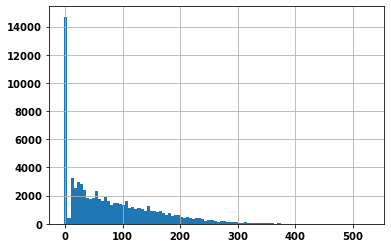

In [6]:
# Histogram plot
df.total_sunspot_number.hist(bins=100)

In [7]:
# Value counts
df.total_sunspot_number.value_counts()

 0      11347
-1       3247
 12      1319
 27       922
 23       921
        ...  
 484        1
 356        1
 463        1
 518        1
 335        1
Name: total_sunspot_number, Length: 438, dtype: int64

<AxesSubplot:xlabel='date'>

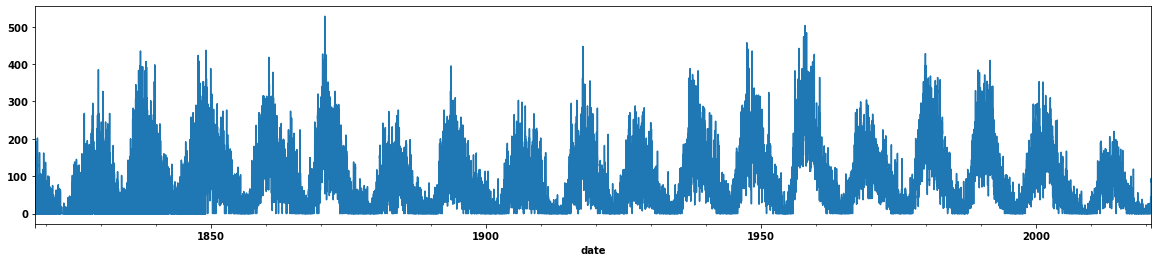

In [8]:
# Visualize the data
df.total_sunspot_number.plot(figsize=(20,4))

## <a name="DataPreprocessing">Data Preprocessing

Total number of sunspot = -1 means that there are no calculation on that particular day.  We remove them and replace by value from the previous day.

In [9]:
df.total_sunspot_number = np.where((df.total_sunspot_number == -1), np.NAN, df.total_sunspot_number)
df.dropna(axis=0,inplace=True)
ts  = df.total_sunspot_number.asfreq(freq='d', method='bfill')

In [10]:
ts = ts.resample('M').sum()

<AxesSubplot:xlabel='date'>

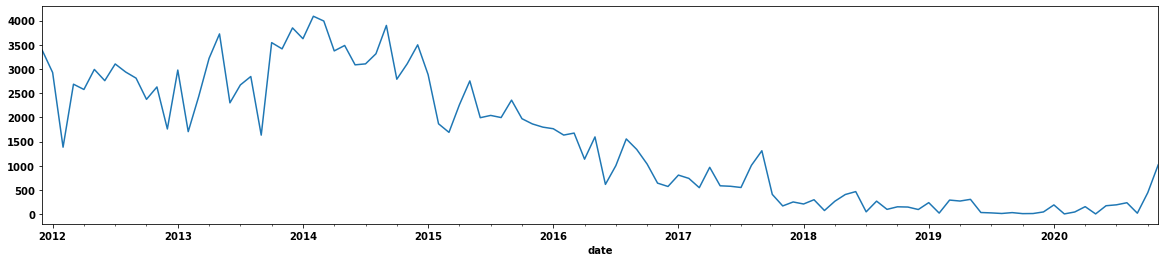

In [11]:
#last plot the data of the past nine years
ts[-12*9:].plot(figsize=(20,4))

The seasonality plot shows that there is seasonality in the data

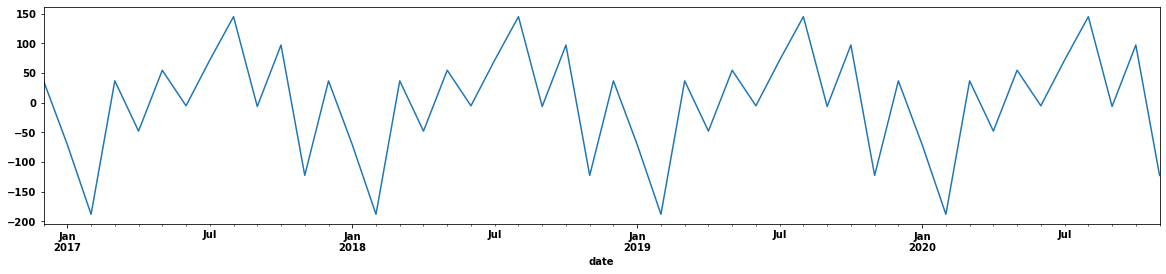

In [12]:
result = seasonal_decompose(ts, model='additive')
result.seasonal[-12*4:].plot(figsize=(20, 4))
plt.show()

## <a name="DataSpliting">Data Splitting

Before we perform analysis on the data, let us split the data into training set and test set.

In [13]:
train_set, test_set =  train_test_split(ts,train_size = split_ratio, shuffle=False)
train_axis = train_set.index
test_axis = test_set.index

## <a name="DataScaling ">Data Scaling

In [14]:
train_set_arr = train_set.values
test_set_arr = test_set.values

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = StandardScaler()

scaler.fit(train_set_arr.reshape(-1,1))

train_norm = scaler.transform(train_set_arr.reshape((-1,1)))
test_norm = scaler.transform(test_set_arr.reshape((-1,1)))

## <a name="DataSequencing">Data Sequencing

In [15]:
from torch.utils.data import Dataset, DataLoader

class SunspotDataSet(Dataset):
    def __init__(self, data, input_window_size, num_future):
        self.data = torch.Tensor(data)
        self.input_window_size = input_window_size
        self.num_future = num_future
    
    def __len__(self):
        return len(self.data) - self.input_window_size - self.num_future
    
    def __getitem__(self, idx):
        X = self.data[idx:idx + self.input_window_size]
        y = self.data[idx+self.input_window_size:idx + self.input_window_size + self.num_future]
        return X,y

In [16]:
train_ds = SunspotDataSet(data=train_norm, input_window_size = window_size, num_future = num_futures)
test_ds = SunspotDataSet(data=test_norm, input_window_size = window_size, num_future = num_futures)

train_loader = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, drop_last=True)

## <a name="Model building">Model building (Univariate Seq2Seq)

In [17]:
class EncoderRNN(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, num_features, num_hidden):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size, batch_first=True)
        
     
    def forward(self, seq):
        h0 = torch.zeros(1, seq.size(0), self.hidden_size)
        c0 = torch.zeros(1, seq.size(0), self.hidden_size)
        out_lstm, hidden = self.lstm(seq, (h0.detach(),c0.detach()))
    ### END SOLUTION
        return hidden
    
class DecoderRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super().__init__()
        ### BEGIN SOLUTION
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = num_features
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        
    def forward(self, seq, hidden):
        out_lstm, out_hidden = self.lstm(seq, hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        out = torch.unsqueeze(out,2)
        ### END SOLUTION
        return out, out_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures):
        super().__init__()
        ### BEGIN SOLUTION
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures
        
        self.encoder = EncoderRNN(self.num_features, self.num_hidden)
        self.decoder = DecoderRNN(self.num_features, self.num_hidden, self.num_output)
        

    
    def forward(self, seq, prev_y):
        encoder_hidden = self.encoder(seq)  
        prev_hidden = encoder_hidden
        
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        
        #placeholder for decoder output
        targets_ta = []
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out)
        
        targets = torch.cat(targets_ta, dim=1)
        ### END SOLUTION
        return targets

## <a name="InputModel">Input Model

In [18]:
torch.manual_seed(42)

model = Seq2Seq(num_features, num_hidden, num_output, num_futures)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

In [19]:
# Model Summary
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs,inputs[:,[-1],:]))

                        Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                                                
0_encoder.LSTM_lstm                -  [14, 21, 50]   10600      10200
1_decoder.LSTM_lstm                -   [14, 1, 50]   10600      10200
2_decoder.Linear_linear      [50, 1]       [14, 1]      51         50
---------------------------------------------------------------------
                      Totals
Total params           21251
Trainable params       21251
Non-trainable params       0
Mult-Adds              20450
                        Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                                                
0_encoder.LSTM_lstm                -  [14, 21, 50]   10600      10200
1_decoder.LSTM_lstm                -   [14, 1, 50]   10600      10200
2_decoder.Linear_linear      [50, 1]       [14, 1]      51         50


## <a name="Training">Training
Pipeline :
- Initialize epoch loss and running loss to zero for later use
- Forward Pass
- Calculate MSE
- Zero out optimizer gradient 
- Backward Pass
- Optimizer update 
- Compute running loss for each iteration
- Compute the epoch loss

>**Instruction** : <br>
Create the training function to train the model.

In [20]:
# Training function
def training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    ### BEGIN SOLUTION
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cumulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for train_X,train_Y in train_iter:
            
            train_input = train_X[:,[-1],:]
            # Forward pass
            y_train_pred = model(train_X,train_input)
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for test_X,test_Y in test_iter:
                
                test_input = test_X[:,[-1],:]
                
                y_test_pred = model(test_X,test_input)
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    ### END SOLUTION
    return train_loss,val_loss

In [21]:
train_loss,val_loss = training(num_epochs,
                               train_loader,
                               test_loader,
                               optimizer,
                               criterion, 
                               model)


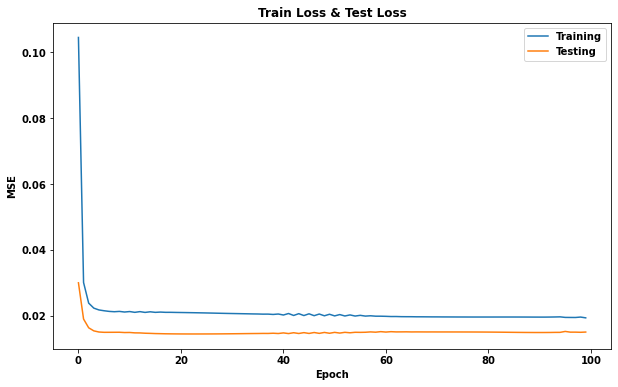

Epoch : 0 , training loss : 0.10448715746885566 , validation loss : 0.03002521622274465
Epoch : 1 , training loss : 0.030110290438472763 , validation loss : 0.019023596281376214
Epoch : 2 , training loss : 0.023851438948796568 , validation loss : 0.01636810591923827
Epoch : 3 , training loss : 0.022335123836959705 , validation loss : 0.015435259060360154
Epoch : 4 , training loss : 0.02178602387440874 , validation loss : 0.015088625896553942
Epoch : 5 , training loss : 0.021541336372775145 , validation loss : 0.014993646140249738
Epoch : 6 , training loss : 0.02134390096914485 , validation loss : 0.015000101767693171
Epoch : 7 , training loss : 0.021246021042614468 , validation loss : 0.015005480723353089
Epoch : 8 , training loss : 0.021342543662386183 , validation loss : 0.015014143132280207
Epoch : 9 , training loss : 0.02115294890681461 , validation loss : 0.01492773707724887
Epoch : 10 , training loss : 0.021297632915858736 , validation loss : 0.014947484029333498
Epoch : 11 , tra

In [22]:
def learning_curve(num_epochs,train_loss,val_loss):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Train Loss & Test Loss")
    plt.show()
    for i in range(num_epochs):
        print(f'Epoch : {i} , training loss : {train_loss[i]} , validation loss : {val_loss[i]}')
    
learning_curve(num_epochs,train_loss,val_loss)

## <a name="SaveandLoadModel">Save and Load Model

In [23]:
torch.save(model.state_dict(), '../../Trained_models/sunspot.pt')

In [50]:
model = Seq2Seq(num_features, num_hidden, num_output, num_futures)
model.load_state_dict(torch.load('../../Trained_models/sunspot.pt'))

<All keys matched successfully>

## <a name="ModelEvaluation">Model Evaluation

In [51]:
with torch.no_grad():
    # Place holder
    predict_testset = []
    actual_testset = []
    predict_trainset = []
    actual_trainset= []
    
    # Iterate the train data iterator
    for idx in range(len(train_ds)):
        # Reshape to ensure the shape is match with requirement for LSTM model input
        train_feature = torch.unsqueeze(train_ds[idx][0],0)
        train_label = torch.unsqueeze(train_ds[idx][1],0)
        
        # Model Inferencing
        train_prediction = model(train_feature,train_feature[:,[-1],:])
        
        # Append the actual and predict data to the place holder
        actual_trainset.append(train_label)
        predict_trainset.append(train_prediction)
        
    # Iterate the test data iterator    
    for idx in range(len(test_ds)):
        # Reshape to ensure the shape is match with requirement for LSTM model input
        test_feature = torch.unsqueeze(test_ds[idx][0],0)
        test_label = torch.unsqueeze(test_ds[idx][1],0)
        
        # Model Inferencing
        test_prediction = model(test_feature,test_feature[:,[-1],:])
        actual_testset.append(test_label)
        
        # Append the actual and predict data to the place holder
        predict_testset.append(test_prediction)
        
# Concatenate the place holder 
trainset_actual_holder = torch.cat(actual_trainset,dim=0)
trainset_predict_holder = torch.cat(predict_trainset,dim=0)        
testset_actual_holder = torch.cat(actual_testset,dim=0)
testset_predict_holder = torch.cat(predict_testset,dim=0)

### <a name="InverseScaleTransform">Inverse Scale Transform

In [52]:
# Inverse Transform
trainset_actual = scaler.inverse_transform(trainset_actual_holder.reshape(-1,1))
trainset_predict = scaler.inverse_transform(trainset_predict_holder .reshape(-1,1))
testset_actual = scaler.inverse_transform(testset_actual_holder .reshape(-1,1))
testset_predict = scaler.inverse_transform(testset_predict_holder.reshape(-1,1))

In [53]:
# Reshape the inversed data
trainset_actual = trainset_actual.reshape(len(trainset_actual_holder),num_futures)
trainset_predict = trainset_predict.reshape(len(trainset_predict_holder),num_futures)
testset_actual = testset_actual.reshape(len(testset_actual_holder),num_futures)
testset_predict = testset_predict.reshape(len(testset_predict_holder),num_futures)

### <a name="ForecastDataEvaluation">Forecast Data Evaluation

In [54]:
print("Test Data\t\t\tForecast")
for test, forecast in zip(testset_actual,testset_predict):   
    print(f"{test}\t\t{forecast}")

Test Data			Forecast
[1664.99991781]		[2637.98709399]
[1393.9999266]		[2110.0707294]
[1762.99987787]		[1871.51615044]
[1708.9998931]		[1911.70013168]
[2007.00004271]		[1763.43450209]
[2010.99998009]		[1768.59155592]
[1975.99994692]		[1681.78922915]
[1920.00015947]		[1599.16845891]
[1786.99983421]		[1590.6738629]
[973.99986058]		[1610.36443207]
[974.99992794]		[1216.59588039]
[2181.0001412]		[1178.90111062]
[1738.99992153]		[1768.78213981]
[1164.00004065]		[1580.81762141]
[1029.99998006]		[1239.10370436]
[889.99984738]		[1094.16764829]
[984.99993742]		[963.29296419]
[770.00006568]		[941.88747209]
[1251.99999124]		[857.14770123]
[1894.00006843]		[1101.50645596]
[1536.99992931]		[1478.48171195]
[889.00011206]		[1417.87537256]
[1471.00013238]		[1117.6645827]
[1657.00004303]		[1361.66873187]
[1554.00007823]		[1491.01841286]
[1009.99996111]		[1490.93607]
[671.00003827]		[1260.03804919]
[701.0000667]		[1074.48371968]
[732.99989781]		[1034.95748526]
[746.00010934]		[1000.71181896]
[386.0001002

In [55]:
# Calculate root mean squared error for both train and test data
trainScore = math.sqrt(mean_squared_error(trainset_actual, trainset_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testset_actual, testset_predict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 770.49 RMSE
Test Score: 684.43 RMSE


### <a name="ForecastPlot">Forecast Plot

In [56]:
def forecast_plot(actual,predict,test_axis,window_size,num_futures):
        
    # Forecast plot for single step forecast    
    if num_futures == 1:
        plt.figure(figsize=(20,4))
        plt.grid()
        plt.plot(test_axis[window_size+1:],actual,'b',label="Test Data")
        plt.plot(test_axis[window_size+1:],predict,'r--',label="Forecast Data",linewidth=3.0)
        plt.legend()
        plt.title("Daily Sunspot Single Step Forecast")
        
    else:
        # Forecast plot for multi-step forecast
        column_names = ["timestep_" + str(i) for i in range(num_futures)]
        y_test_dataframe = pd.DataFrame(actual,columns = column_names)
        y_test_pred_dataframe =pd.DataFrame(predict,columns = column_names)
        time_index_after_sequence = test_axis[window_size:]
        plt.figure(figsize=(20,4))
        
        # For loop to plot the data step by step base on time index    
        start_idx = 0 
        for row in range(len(y_test_dataframe)):

            # Iterate the time index after sequence
            time_index = time_index_after_sequence[start_idx:start_idx+num_futures]

            # Plot the test data
            plt.plot(time_index,y_test_dataframe.iloc[row],color="b",marker='o')

            # Plot the forecast data
            plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')

            # Pointer for time_index_after_sequence
            start_idx += 1

        custom_lines = [Line2D([0], [0], color="green", lw=4),
                    Line2D([0], [0], color="red", lw=4),]
        plt.legend(custom_lines, ['Test Data', 'Forecast Data'])
        plt.title("Daily Sunspot Multi Step Forecast")

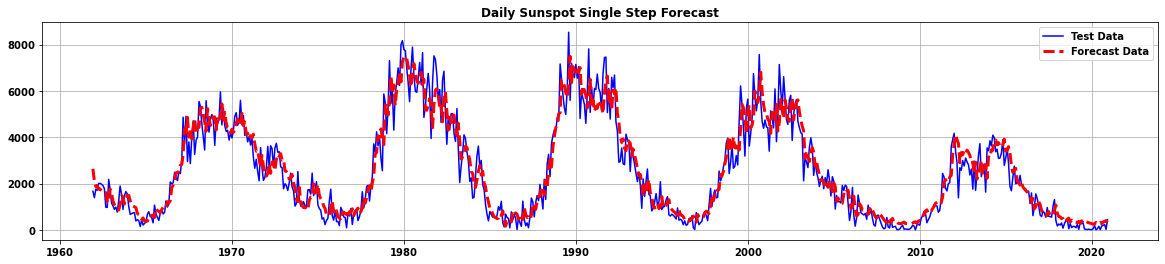

In [57]:
forecast_plot(testset_actual,testset_predict,test_axis,window_size,num_futures)

## <a name="Summary">Summary
From this tutorial, you should have learned:
1. Apply Seq2Seq model to the Sunspot data.
2. Apply data exploratory to the Sunspot data.
3. Save and load the model.    
    
Congratulations, that concludes this lesson.<br>
    

## <a name="Reference">Reference
1. [DEPLOYING A SEQ2SEQ MODEL WITH TORCHSCRIPT](https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html)